#### Objective

With this workflow I import an image with a map, isolate the map using morphological operations, then reduce the number of colours with segmentation. The resulting image is the input to a colormap recognition and data extration workflow.

#### Preliminaries - import main libraries

In [1]:
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage import segmentation, color, io
from skimage.color import rgb2gray 

from skimage.morphology import disk, square, closing, opening, erosion, dilation
from skimage.morphology import reconstruction, remove_small_objects

%matplotlib inline

#### Import test image

In [2]:
#url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test1.png'
#url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test2.png'
url = 'https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebooks/test_with_text.png'

img = np.asarray(io.imread(url))[:,:,:3] # removing alpha channel

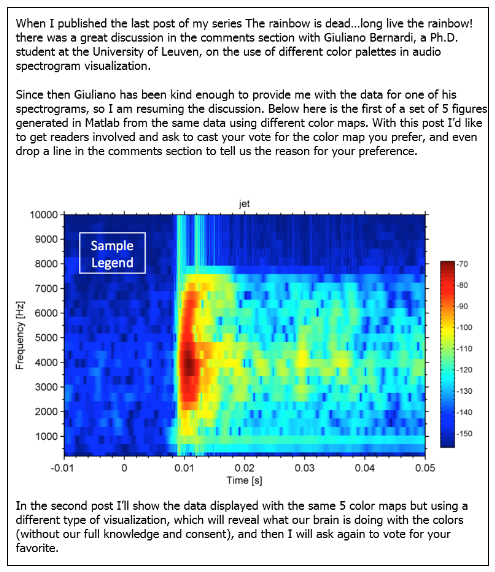

In [3]:
# Plot image
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
plt.imshow(img)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
plt.show()

#### Find the map

We want to eliminate both possibilities of ~black and ~nearly white border

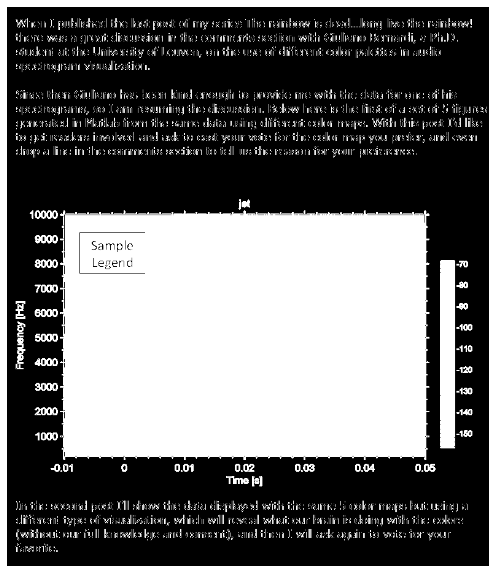

In [4]:
binary = np.logical_and(color.rgb2gray(img) > 0.02, color.rgb2gray(img) < 0.98)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Get largest element in ghe binary image and use it as a mask for the original image

Detect largest bright element in the binary image. Making the assumption it would be the map.
Eliminate everything else (text, colorbar, etc.).

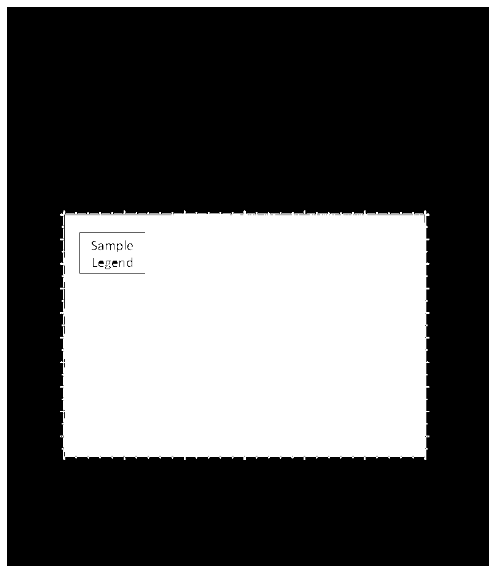

In [5]:
# Label all white objects ( made up of ones)
label_objects, nb_labels = ndi.label(binary) # ndimage.label labels 0 (background) as 0 and then labels every nonzero
                                                    # object as 1, 2, ... n. 
    
# Calculate every labeled object's size. np.bincount ignores whether input is an image or another type of array.
# It just calculates the binary sizes, including for the 0 (background).
sizes = np.bincount(label_objects.ravel())   
sizes[0] = 0    # This sets the size of the background to 0 so that if it happened to be larger than the larges bright
                # object it would not matter

# Keep only largest object
binary_cleaned = remove_small_objects(binary, max(sizes)) # this works but seems to make the mask below not work.

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(binary_cleaned, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Close small gaps

If present, eliminates small dark objects inside the largest object with closing, and tick marks with erosion. The former can be replaced by scikit-image morphology.remove_small_holes once done the update.

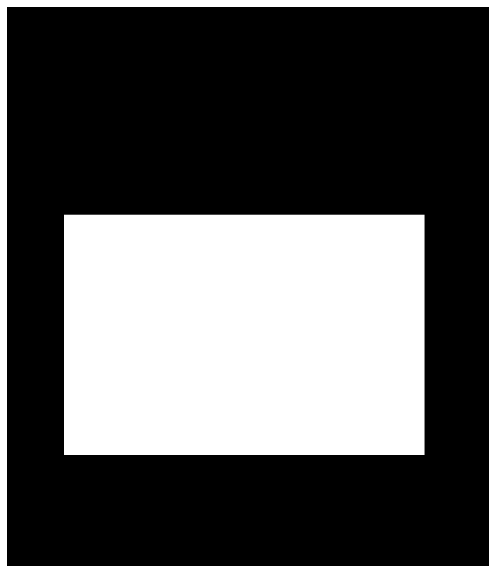

In [6]:
closed = closing(binary_cleaned, square(6))  # have to make structuring element size based on image size heuristic
closed = erosion(closed, square(6))  # a little extra erosion in case original image had tick marks

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(closed, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

In [7]:
# Convert cleaned binary image to a 3D array mask to use in next cell

mask3 = np.zeros(img.shape)
mask3[:,:,0] = closed
mask3[:,:,1] = closed
mask3[:,:,2] = closed

#print np.amin(mask3), np.amax(mask3)

In [8]:
# Use the mask to get only the map in the original image
final = np.ma.masked_where(mask3 ==0, img)
final = final.filled(0)

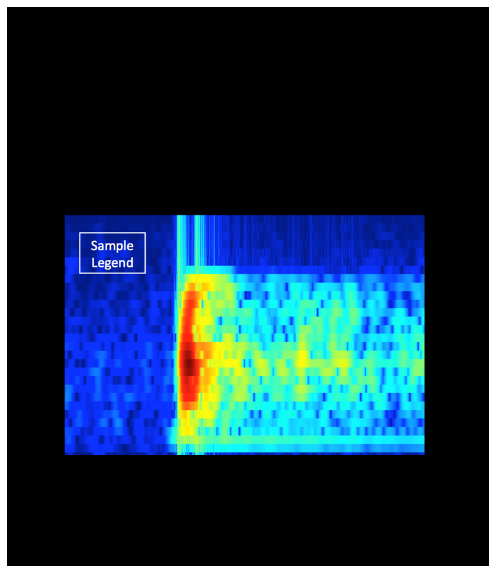

In [9]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(final)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

#### Crop zero columns and zero rows

http://stackoverflow.com/a/14211727/1034648

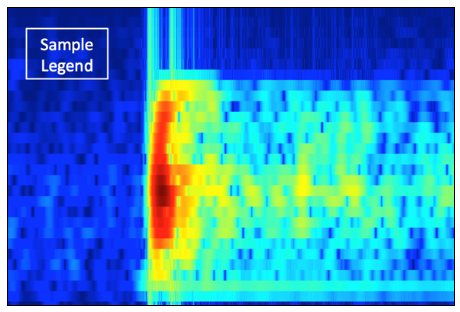

In [10]:
non_empty_columns = np.where(final.max(axis=0)>0)[0]
non_empty_rows = np.where(final.max(axis=1)>0)[0]
cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))

final_crop = final[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.imshow(final_crop, cmap='gray')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()

N.B. The workflow seems to work even when the map touches the border, as in:
https://raw.githubusercontent.com/mycarta/rainbowbot/master/stuff4matching_cmap_notebook/test2.png

#### Reduce number of colours

I use here Scikit-learn segmentation using k-means clustering in Color-(x,y,z) space:
http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

In [11]:
labels1 = segmentation.slic(final_crop, compactness=30, n_segments=32, convert2lab = 'True') 
out1 = color.label2rgb(labels1, final_crop, kind='avg')

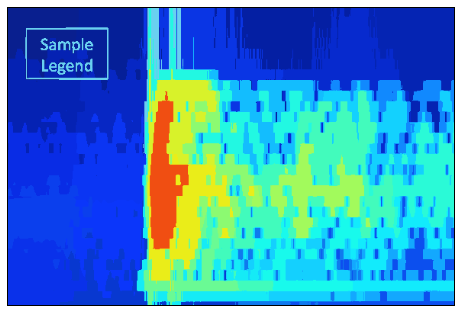

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.imshow(out1)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
plt.show()